In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import time

# Set a nice style for the plots
sns.set_theme(style="whitegrid")
print("Libraries imported successfully.")

import os

def get_figures_path():
    target_suffix = os.path.join("Contrastive_Learning", "code", "ML_model", "figures")
    cwd = os.path.abspath(os.getcwd())
    parts = cwd.split(os.sep)
    for i in range(len(parts), 0, -1):
        candidate = os.sep.join(parts[:i])
        test_path = os.path.join(candidate, target_suffix)
        if os.path.isdir(test_path):
            return test_path
    raise FileNotFoundError(f"Path ending with '{target_suffix}' not found")


Libraries imported successfully.


In [2]:


def load_single_run_results(results_folder: str, run_name: str=None) -> pd.DataFrame:
    """Loads the Spearman correlation results for a single, specified run."""

    if run_name:
        filepath = Path(results_folder) / run_name / "tsplice_spearman_by_tissue.tsv"
    else:
        filepath = Path(results_folder) / "tsplice_spearman_by_tissue.tsv"
    print(f"Loading single run results from: {filepath}")
    
    # Load the tab-separated file
    df = pd.read_csv(filepath, sep='\t')
    
    # --- ADDED THIS STEP ---
    # Standardize column names to match the expected format ('spearman_rho_...')
    # This handles files that might have the older 'spearman_psi' naming.
    rename_dict = {
        'spearman_psi': 'spearman_rho_psi',
        'spearman_delta': 'spearman_rho_delta_psi'
    }
    df.rename(columns=rename_dict, inplace=True)
    
    return df


print("Data loading functions defined.")

Data loading functions defined.


In [3]:
def _prepare_single_model_df(df, metric, model_name):
    """Internal helper to prepare one DataFrame for comparison."""
    is_averaged = f'mean_{metric}' in df.columns
    metric_col = f'mean_{metric}' if is_averaged else metric
    std_col = f'std_{metric}' if is_averaged else None

    cols_to_select = ['tissue', metric_col]
    if is_averaged and std_col and std_col in df.columns:
        cols_to_select.append(std_col)
    
    plot_df = df[cols_to_select].copy()
    plot_df.rename(columns={metric_col: model_name}, inplace=True)
    return plot_df

def prepare_grouped_plot_data(df1, df2, df3, metric, model1_name, model2_name, model3_name):
    """
    Prepares and merges data from three models for a grouped bar plot.

    Args:
        df1 (pd.DataFrame): DataFrame for the first model.
        df2 (pd.DataFrame): DataFrame for the second model.
        metric (str): The base metric name (e.g., 'spearman_rho_psi').
        model1_name (str): Custom name for the first model.
        model2_name (str): Custom name for the second model.

    Returns:
        tuple[pd.DataFrame, pd.DataFrame]: A tuple containing:
            - comparison_df: The merged, wide-format DataFrame.
            - melted_df: The long-format DataFrame ready for seaborn.
    """
    model1_plot_df = _prepare_single_model_df(df1, metric, model1_name)
    model2_plot_df = _prepare_single_model_df(df2, metric, model2_name)
    model3_plot_df = _prepare_single_model_df(df3, metric, model3_name)

    # Merge the three prepared dataframes
    comparison_df = (
    pd.merge(model1_plot_df, model2_plot_df, on='tissue', how='inner')
      .merge(model3_plot_df, on='tissue', how='inner')
)
    # "Melt" the dataframe for seaborn plotting
    melted_df = comparison_df.melt(id_vars='tissue', value_vars=[model1_name, model2_name, model3_name], 
                                   var_name='Model', value_name='Spearman ρ')
    
    return comparison_df, melted_df

In [4]:
def plot_grouped_comparison(comparison_df, melted_df, title,
                            model1_name, model2_name, model3_name,
                            save_path=None):
    """
    Generates a grouped bar plot with improved clarity and readable labels.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd

    plt.figure(figsize=(18, 8))
    ax = sns.barplot(
        data=melted_df,
        x='tissue', y='Spearman ρ', hue='Model',
        palette={
            model1_name: 'lightgray',
            model2_name: 'mediumseagreen',
            model3_name: 'cornflowerblue'
        },
        # edgecolor='black', linewidth=0.3,  # crisper bars
        linewidth=0.4,  # crisper bars
        width=0.7                         # slightly wider bars
    )

    # --- Optional error bars if present ---
    std_col = [col for col in comparison_df.columns if col.startswith('std_')]
    if std_col:
        error_map = comparison_df.set_index('tissue')[std_col[0]].to_dict()
        for patch in ax.patches:
            center_x = patch.get_x() + patch.get_width() / 2
            height = patch.get_height()
            tissue_idx = int(center_x // len(melted_df['Model'].unique()))
            tissue_name = ax.get_xticklabels()[tissue_idx].get_text() if tissue_idx < len(ax.get_xticklabels()) else None
            if tissue_name in error_map:
                ax.errorbar(center_x, height, yerr=error_map[tissue_name],
                            fmt='none', capsize=3, color='black', lw=0.8)

    # --- Styling for clarity ---
    ax.set_title(title, fontsize=16, pad=20, weight='bold')
    ax.set_ylabel('Spearman ρ', fontsize=13)
    ax.set_xlabel('Tissue', fontsize=13)

    # Rotate x-tick labels for readability
    plt.xticks(rotation=90, ha='center', fontsize=9)
    plt.yticks(fontsize=10)

    # Clean legend: move to top center, horizontal layout
    plt.legend(title='Model', fontsize=10, title_fontsize=11,
               loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3,
               frameon=False)

    # Add a subtle grid
    ax.grid(axis='y', linestyle='--', alpha=0.4)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"📊 Figure saved to: {save_path}")

    plt.show()



def plot_average_across_tissues_2models(
    df1, df2, df3, model1_name, model2_name, model3_name,
    metric, save_path=None
):
    """
    Compute and plot the average metric across all tissues for 2 models.
    Each dataframe must contain 'tissue' and the target metric column.

    Args:
        df1, df2, df3: DataFrames containing per-tissue metric values.
        model1_name, model2_name, model3_name: Model labels for legend.
        metric: str, metric column name (e.g. 'spearman_rho_psi').
        save_path: Optional path to save the figure.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd

    # Compute averages
    avg_df = pd.DataFrame({
        'Model': [model1_name, model2_name, model3_name],
        'Average': [
            df1[metric].mean(),
            df2[metric].mean(),
            df3[metric].mean()
        ]
    })

    # Determine dynamic y-axis range
    y_min = max(0, avg_df["Average"].min() - 0.05)
    y_max = min(1.0, avg_df["Average"].max() + 0.1)

    # Plot
    plt.figure(figsize=(6, 5))
    sns.barplot(data=avg_df, x='Model', y='Average', palette='viridis')

    plt.ylabel(f"Average {metric.replace('_', ' ').title()}")
    plt.title(f"Average {metric.replace('_', ' ').title()} Across All Tissues")
    plt.ylim(y_min, y_max)
    plt.xticks(rotation=25, ha='right')
    plt.tight_layout()

    # Save and show
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"✅ Saved average plot: {save_path}")

    plt.show()
    return avg_df

In [ ]:
# ################ 2 user inputs WITH SOTA ################


In [5]:
# --- Assuming imports and previous helper functions are defined ---
# Make sure load_sota_results, load_single_run_results, load_and_average_all_runs are available

# --- Configuration ---
# --- Folder 1 ---
result_file_name1 = "exprmnt_2025_11_05__01_50_41" # EMPRAIPsi_TS_noCL_300bp_rerun_codeChange_2025_11_05__01_50_41
model1_user_name_norun = 'TS_noCL_300bp_rerun_codeChange'
model1_user_name = f'{model1_user_name_norun}_ensembled'
model1_user_avg_name = f'{model1_user_name_norun}_avg'
model1_runNumber = None


# --- Folder 2 (Define paths and names for your second experiment) ---
result_file_name2 =  "exprmnt_2025_11_05__01_52_25" # EMPRAIPsi_TS_CLSwpd_300bp_10Aug_rerun_codeChange_2025_11_05__01_52_25
model2_user_name_norun = 'TS_CLSwpd_300bp_10Aug'
model2_user_name = f'{model2_user_name_norun}_ensembled'
model2_user_avg_name = f'{model2_user_name_norun}_avg'
model2_runNumber = None


# --- Folder 3 (Define paths and names for your second experiment) ---
result_file_name3 =  "exprmnt_2025_11_05__01_52_25" # EMPRAIPsi_TS_CLSwpd_300bp_10Aug_rerun_codeChange_2025_11_05__01_52_25
model3_user_name_norun = 'TS_CLSwpd_300bp_10Aug_ignore'
model3_user_name = f'{model3_user_name_norun}_ensembled'
model3_user_avg_name = f'{model3_user_name_norun}_avg'
model3_runNumber = None


In [6]:
# --- Base Dirs ---
main_dir = "/gpfs/commons/home/atalukder/Contrastive_Learning/files/results/"
# main_dir = "/mnt/home/at3836/Contrastive_Learning/files/results/"
fig_maindir = get_figures_path()
trimester = time.strftime("_%Y_%m_%d__%H_%M_%S")

# --- Full Paths ---
RESULTS_FOLDER_PATH1 = f"{main_dir}/{result_file_name1}/ensemble_evaluation_from_valdiation/test_set_evaluation" # <<< Path for Folder 1
RESULTS_FOLDER_PATH2 = f"{main_dir}/{result_file_name2}/ensemble_evaluation_from_valdiation/test_set_evaluation" # <<< Path for Folder 2
RESULTS_FOLDER_PATH3 = f"{main_dir}/{result_file_name3}/ensemble_evaluation_from_valdiation/test_set_evaluation" # <<< Path for Folder 3

In [7]:
# --- Load Data ---
print("--- Loading Data ---")
try:
    
    single_run_1_results = load_single_run_results(RESULTS_FOLDER_PATH1)
    # averaged_run_1_results = load_and_average_all_runs(RESULTS_FOLDER_PATH1)
    print(f"Loaded Folder 1: {result_file_name1}")

    # Results for Folder 2 (Single Run & Averaged)
    single_run_2_results = load_single_run_results(RESULTS_FOLDER_PATH2)
    # averaged_run_2_results = load_and_average_all_runs(RESULTS_FOLDER_PATH2)
    print(f"Loaded Folder 2: {result_file_name2}")

    # Results for Folder 3 (Single Run & Averaged)
    single_run_3_results = load_single_run_results(RESULTS_FOLDER_PATH3)
    # averaged_run_3_results = load_and_average_all_runs(RESULTS_FOLDER_PATH3)
    print(f"Loaded Folder 3: {result_file_name3}")
    
except FileNotFoundError as e:
    print(f"Error loading files: {e}")
    exit()
except Exception as e:
    print(f"An unexpected error occurred during loading: {e}")
    exit()

--- Loading Data ---
Loading single run results from: /gpfs/commons/home/atalukder/Contrastive_Learning/files/results/exprmnt_2025_11_05__01_50_41/ensemble_evaluation_from_valdiation/test_set_evaluation/tsplice_spearman_by_tissue.tsv
Loaded Folder 1: exprmnt_2025_11_05__01_50_41
Loading single run results from: /gpfs/commons/home/atalukder/Contrastive_Learning/files/results/exprmnt_2025_11_05__01_52_25/ensemble_evaluation_from_valdiation/test_set_evaluation/tsplice_spearman_by_tissue.tsv
Loaded Folder 2: exprmnt_2025_11_05__01_52_25
Loading single run results from: /gpfs/commons/home/atalukder/Contrastive_Learning/files/results/exprmnt_2025_11_05__01_52_25/ensemble_evaluation_from_valdiation/test_set_evaluation/tsplice_spearman_by_tissue.tsv
Loaded Folder 3: exprmnt_2025_11_05__01_52_25


In [ ]:
################ 2 user inputs ################

📊 Figure saved to: /gpfs/commons/home/atalukder/Contrastive_Learning/code/ML_model/figures/spearman_rho_psi_TS_noCL_300bp_rerun_codeChange_ensembled_vs_TS_CLSwpd_300bp_10Aug_ensembledvs_TS_CLSwpd_300bp_10Aug_ignore_ensembled_2025_11_05__19_08_11.png


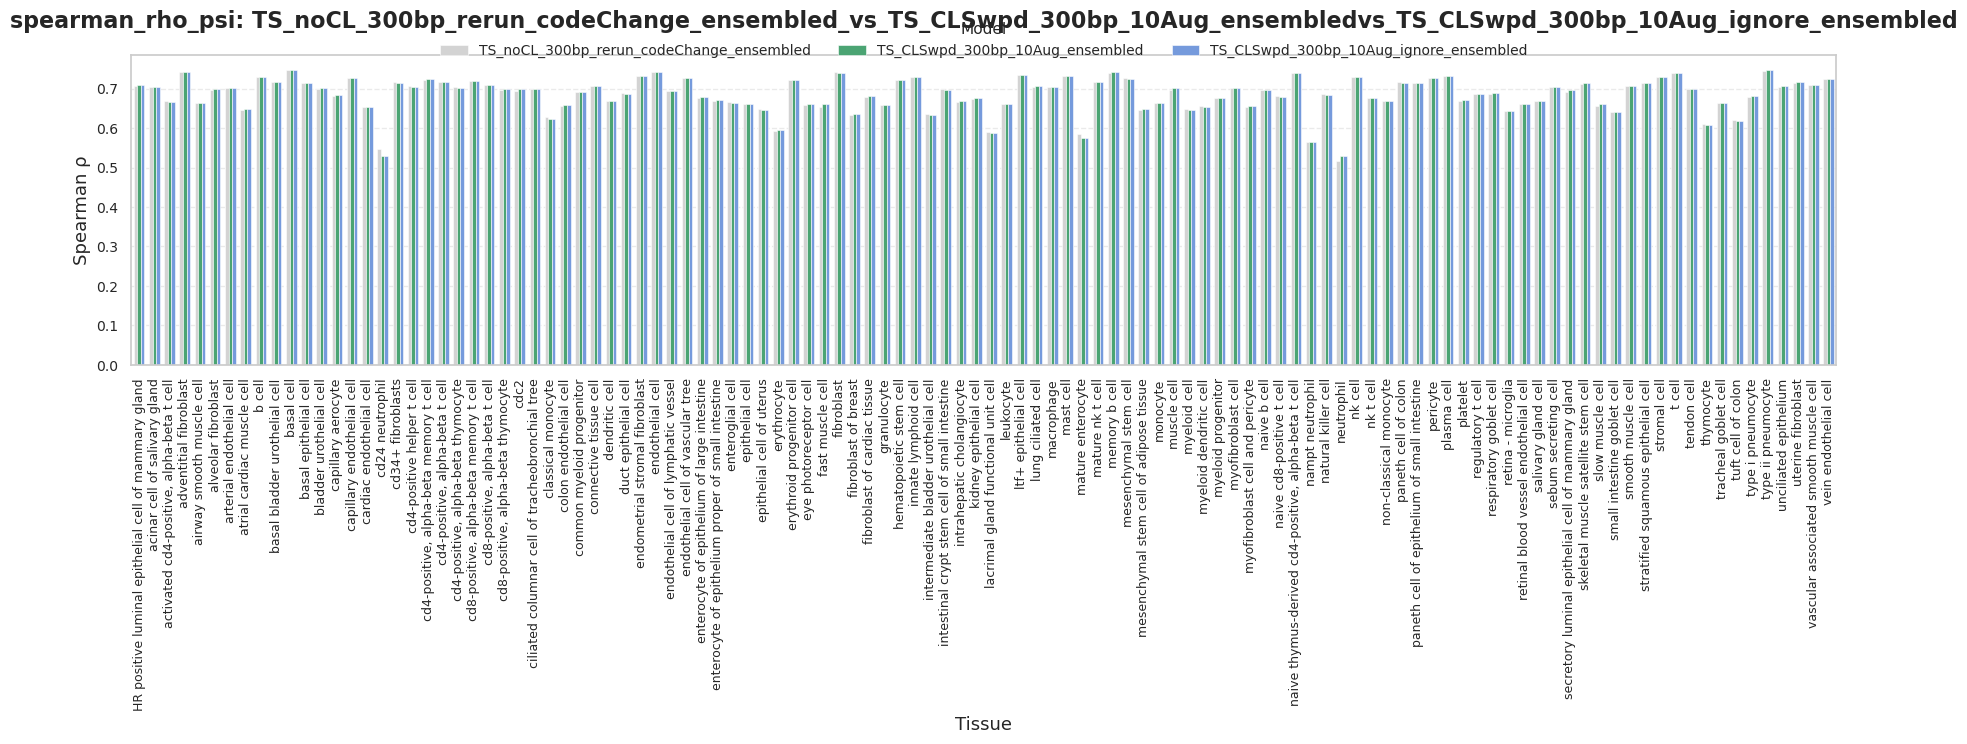

📊 Figure saved to: /gpfs/commons/home/atalukder/Contrastive_Learning/code/ML_model/figures/spearman_rho_delta_psi_TS_noCL_300bp_rerun_codeChange_ensembled_vs_TS_CLSwpd_300bp_10Aug_ensembledvs_TS_CLSwpd_300bp_10Aug_ignore_ensembled_2025_11_05__19_08_11.png


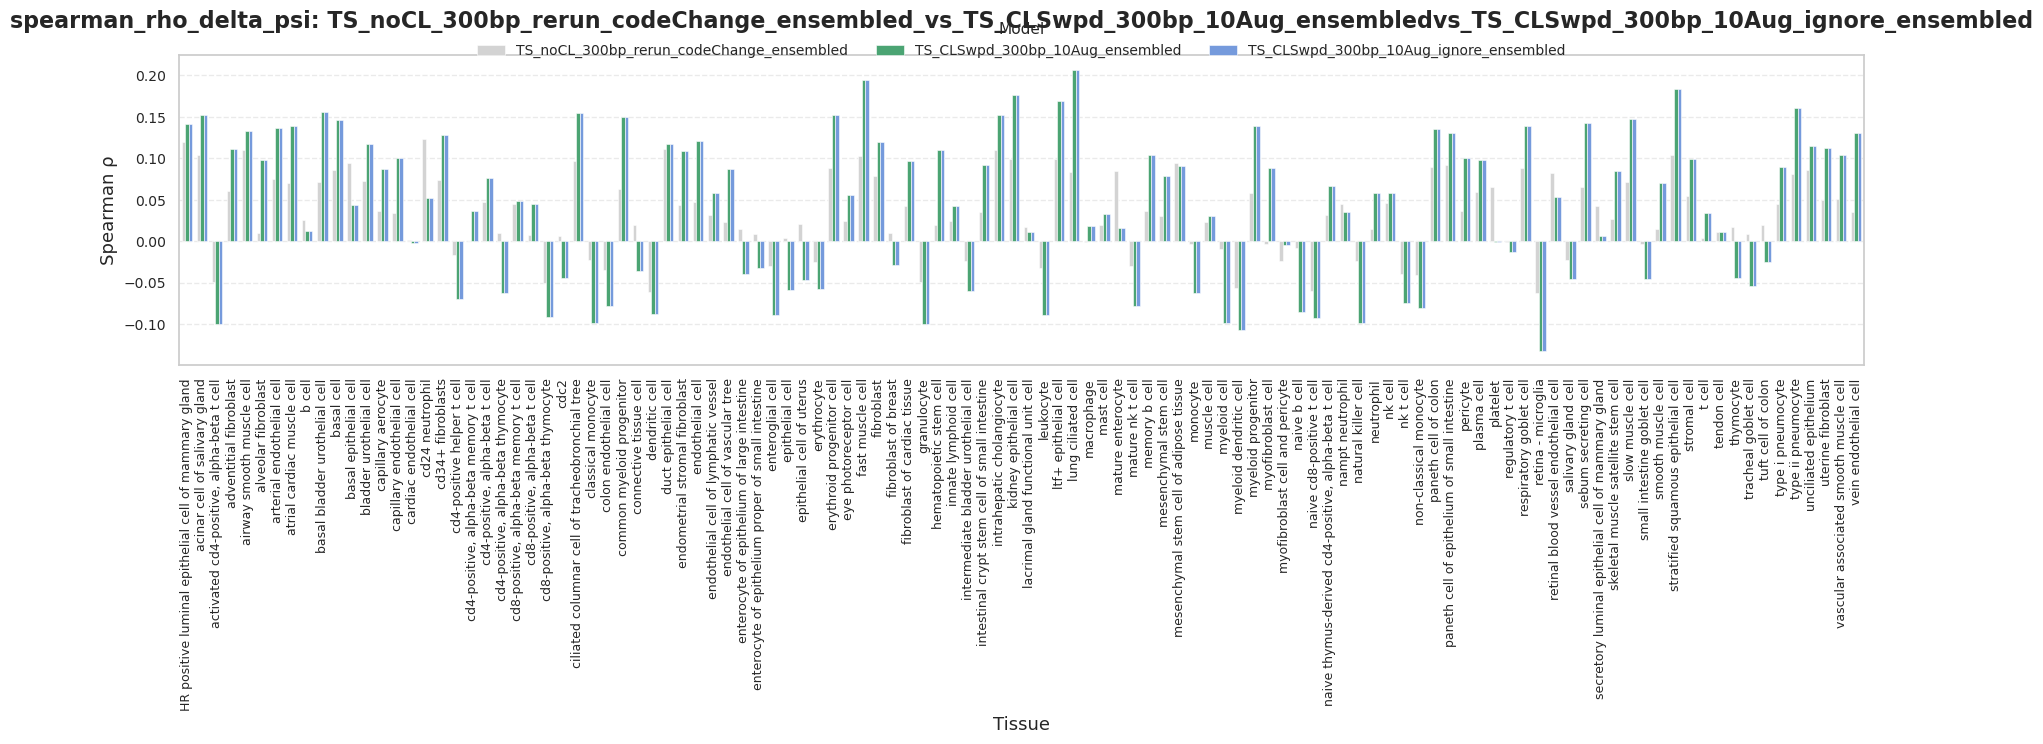

In [8]:
# Prepare the data
# Prepare the data SINGLE RUN 1 vs SINGLE RUN 2

title_single = f"{model1_user_name}_vs_{model2_user_name}vs_{model3_user_name}"
metric_psi = 'spearman_rho_psi'
metric_delta = 'spearman_rho_delta_psi'

import time
trimester = time.strftime("_%Y_%m_%d__%H_%M_%S")
fig_maindir = get_figures_path()

comp_df_1, melt_df_1 = prepare_grouped_plot_data(
    df1=single_run_1_results,
    df2=single_run_2_results,
    df3=single_run_3_results,
    metric=metric_psi,
    model1_name=model1_user_name,
    model2_name=model2_user_name,
    model3_name=model3_user_name
)

# Create the plot
plot_grouped_comparison(
    comp_df_1, melt_df_1,
    title=f'{metric_psi}: {title_single}',
    model1_name=model1_user_name,
    model2_name=model2_user_name,
    model3_name=model3_user_name,
    save_path=f"{fig_maindir}/spearman_rho_psi_{title_single}{trimester}.png"
)

# Prepare the data
comp_df_1, melt_df_1 = prepare_grouped_plot_data(
    df1=single_run_1_results,
    df2=single_run_2_results,
    df3=single_run_3_results,
    metric=metric_delta,
    model1_name=model1_user_name,
    model2_name=model2_user_name,
    model3_name=model3_user_name
)

# Create the plot
plot_grouped_comparison(
    comp_df_1, melt_df_1,
    title=f'{metric_delta}: {title_single}',
    model1_name=model1_user_name,
    model2_name=model2_user_name,
    model3_name=model3_user_name,
    save_path=f"{fig_maindir}/spearman_rho_delta_psi_{title_single}{trimester}.png"
)





In [ ]:
print("\n--- Plotting Average Spearman Correlations Across All Tissues ---")

avg_psi = plot_average_across_tissues_2models(
   single_run_1_results, single_run_2_results, single_run_3_results,
model1_user_name, model2_user_name, model3_user_name,
    metric='spearman_rho_psi',
    save_path=f"{fig_maindir}/avg_{metric_psi}_{title_single}{trimester}.png"
)

avg_delta = plot_average_across_tissues_2models(
    single_run_1_results, single_run_2_results, single_run_3_results,
    model1_user_name, model2_user_name, model3_user_name,
    metric='spearman_rho_delta_psi',
    save_path=f"{fig_maindir}/avg_{metric_delta}_{title_single}{trimester}.png"
)

print("\n--- Average Summary ---")
print(avg_psi)
print(avg_delta)


In [9]:
import pandas as pd
import numpy as np

def get_stratified_average(
    model_results_df,
    imbalance_file_path,
    metric,
    low_lim,
    high_lim,
    model_name="Model"
):
    """
    Calculates the average of a metric for a single model,
    stratified by the "Up" vs. "Down" imbalance categories.
    """
    
    # --- 1. Load Imbalance Data ---
    try:
        imbalance_df = pd.read_csv(imbalance_file_path)
    except FileNotFoundError:
        print(f"Error: Imbalance file not found at {imbalance_file_path}")
        return pd.DataFrame()

    # --- 2. Define Binning Logic ---
    def categorize_imbalance(percent_up):
        if pd.isna(percent_up):
            return "N/A"
        # Using the bins we found worked best:
        if percent_up < low_lim:
            return f"1. Slightly Down-Heavy (< {low_lim})"
        elif low_lim <= percent_up <= high_lim:
            return f"2. Highly Balanced ({low_lim} - {high_lim})"
        else: # percent_up > high_lim
            return f"3. Slightly Up-Heavy (> {high_lim})"

    imbalance_df['granular_category'] = imbalance_df['percent_up'].apply(categorize_imbalance)

    # --- 3. Merge Data ---
    imbalance_categories = imbalance_df[['tissue', 'granular_category']]
    merged_df = model_results_df.merge(imbalance_categories, on="tissue")
    
    if merged_df.empty:
        print(f"Error: No tissues matched between results and imbalance file.")
        return pd.DataFrame()
    if metric not in merged_df.columns:
        print(f"Error: Metric '{metric}' not found in the results DataFrame.")
        return pd.DataFrame()

    # --- 4. Calculate Stratified Average ---
    stratified_avg = merged_df.groupby('granular_category')[metric].mean().reset_index()
    stratified_avg = stratified_avg.rename(columns={metric: f'average_{metric}'})
    stratified_avg['model'] = model_name
    
    return stratified_avg

In [10]:
# --- ASSUMING YOUR DATA IS LOADED ---
# single_run_1_results (your DataFrame with metrics)
# model1_user_name (your model's name)
# root_path (from your script)

# --- 1. Define file paths and metric ---
imbalance_file = f"/gpfs/commons/home/atalukder/Contrastive_Learning/data/TS_data/tabula_sapiens/final_data/test_upDown_imbalance.csv"
low_lim = 0.15
high_lim = 0.25
metric_to_calc = 'spearman_rho_delta_psi' # or 'f1', 'auprc', etc.

# --- 2. Run the function for just model 1 ---
avg_model1_stratified = get_stratified_average(
    model_results_df=single_run_1_results,
    imbalance_file_path=imbalance_file,
    metric=metric_to_calc,
    low_lim=low_lim,
    high_lim=high_lim,
    model_name=model1_user_name
)
print(f"Stratified {metric_to_calc} for: {model1_user_name}")
print(avg_model1_stratified)

avg_model2_stratified = get_stratified_average(
    model_results_df=single_run_2_results,
    imbalance_file_path=imbalance_file,
    metric=metric_to_calc,
    low_lim=low_lim,
    high_lim=high_lim,
    model_name=model2_user_name
)


# --- 3. Print the results ---
print(f"Stratified {metric_to_calc} for: {model2_user_name}")
print(avg_model2_stratified)    

Stratified spearman_rho_delta_psi for: TS_noCL_300bp_rerun_codeChange_ensembled
                  granular_category  average_spearman_rho_delta_psi  \
0   1. Slightly Down-Heavy (< 0.15)                        0.040939   
1  2. Highly Balanced (0.15 - 0.25)                        0.026468   
2     3. Slightly Up-Heavy (> 0.25)                        0.034351   

                                      model  
0  TS_noCL_300bp_rerun_codeChange_ensembled  
1  TS_noCL_300bp_rerun_codeChange_ensembled  
2  TS_noCL_300bp_rerun_codeChange_ensembled  
Stratified spearman_rho_delta_psi for: TS_CLSwpd_300bp_10Aug_ensembled
                  granular_category  average_spearman_rho_delta_psi  \
0   1. Slightly Down-Heavy (< 0.15)                        0.076533   
1  2. Highly Balanced (0.15 - 0.25)                        0.030673   
2     3. Slightly Up-Heavy (> 0.25)                        0.029309   

                             model  
0  TS_CLSwpd_300bp_10Aug_ensembled  
1  TS_CLSwpd_300bp_10

In [ ]:
######################################